<a href="https://colab.research.google.com/github/sy-hwang/DeepLearningZeroToAll/blob/master/standalone/lab_04_cifar10_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install pytorch for Google Colab

In [72]:
'''
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
'''

'\n!pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)\n'

IMPORT

In [73]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch.optim as optim
import torch.nn as nn
import torch.utils.data.dataloader

Hyperparameter

In [74]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.lr = 0.001
args.trainsize = 0.8
args.num_workers = 2
args.batch_size = 4
args.in_dim = 32*32*3
args.out_dim=10
args.hidden_dim=100
args.hidden_layer =3
args.act = 'relu'
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.momentum = 0.9
args.epoch=5
print(args)

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Namespace(act='relu', batch_size=4, device=device(type='cpu'), epoch=5, hidden_dim=100, hidden_layer=3, in_dim=3072, lr=0.001, momentum=0.9, num_workers=2, out_dim=10, trainsize=0.8)


Data generation

In [75]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainSet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainSize = int(args.trainsize*len(trainSet))
validateSize = len(trainSet)-trainSize
trainSet, validateSet = torch.utils.data.random_split(trainSet, [trainSize, validateSize])
testSet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
validateLoader = torch.utils.data.DataLoader(validateSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

print(f"set Nums : {len(trainSet), len(validateSet), len(testSet)}")
print(f"batchSize: {args.batch_size} / num Batches : {len(trainSet)//args.batch_size}, {len(validateSet)//args.batch_size}, {len(testSet)//args.batch_size}")

Files already downloaded and verified
Files already downloaded and verified
set Nums : (40000, 10000, 10000)
batchSize: 4 / num Batches : 10000, 2500, 2500


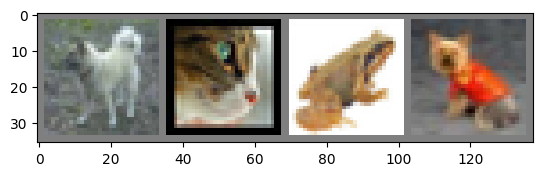

dog   cat   frog  dog  


In [76]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainLoader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(args.batch_size)))

In [77]:
print(type(images), images.shape) #batchsize =4, channnel=3, widthxheight=32x32
print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([5, 3, 6, 5])


Model define

In [78]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim, hidden_layer, act):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hidden_dim = hidden_dim
    self.hidden_layer = hidden_layer

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(in_dim, hidden_dim))
    for _ in range(hidden_layer-1):
      self.layers.append(nn.Linear(hidden_dim, hidden_dim))
    self.outlayer = nn.Linear(hidden_dim, out_dim)

    if(act == 'relu'):
      self.act = nn.ReLU()
    elif(act == 'sigmoid'):
      self.act = nn.Sigmoid()
    elif(act == 'tanh'):
      self.act = nn.Tanh()
    else:
      self.act = nn.ReLU()

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
      x = self.act(x)
    x = self.outlayer(x)
    return x

#model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.hidden_layer, args.act)
#model.to(args.device)
#print(model)

Loss and optimizer

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

Experiment

In [80]:
def train(model : MLP, loader:torch.utils.data.DataLoader, criterion:nn.Module, optimizer:optim.Optimizer):
    running_loss=0
    total=0
    correct = 0
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(args.device), labels.to(args.device)
        inputs = inputs.view(-1, args.in_dim)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss = running_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy
        
#loss, accuracy = train(model, trainLoader, criterion, optimizer)
#print(loss, accuracy)

In [81]:
def evaluate(model : MLP, loader:torch.utils.data.DataLoader, criterion:nn.Module, optimizer:optim.Optimizer):
    val_loss=0
    total=0
    correct = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(args.device), labels.to(args.device)
            inputs = inputs.view(-1, args.in_dim)

            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = val_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy
        
#loss, accuracy = train(model, validateLoader, criterion, optimizer)
#print(loss, accuracy)

In [82]:
def experiment():
    model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.hidden_layer, args.act)
    model.to(args.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    for epoch in range(args.epoch):
        trainLoss, trainAccuracy = train(model, trainLoader, criterion, optimizer)
        valLoss, valAccuracy = evaluate(model, validateLoader, criterion, optimizer)

        print(f"[{epoch}] trainLoss:{trainLoss}, trainAcc:{trainAccuracy}, valLoss:{valLoss}, valAcc:{valAccuracy}")

    _, testAccuracy = evaluate(model, testLoader, criterion, optimizer)
    return testAccuracy

#experiment()


In [83]:
layer_n=[3,4,5]
dim_n=[10, 50, 100]

for layer in layer_n:
    for dim in dim_n:
        args.hidden_layer = layer
        args.hidden_dim = dim
        print(f"{layer}, {dim} : {experiment()}")

[0] trainLoss:1.9308071351230145, trainAcc:28.26, valLoss:1.804340796804428, valAcc:34.6675
[1] trainLoss:1.7651046061635018, trainAcc:36.0775, valLoss:1.7003006706804038, valAcc:38.4525
[2] trainLoss:1.7106247618108987, trainAcc:38.105, valLoss:1.6816087897062302, valAcc:38.71
[3] trainLoss:1.6807909140899777, trainAcc:39.2725, valLoss:1.6691659882903098, valAcc:39.505
[4] trainLoss:1.6607656986624002, trainAcc:40.1775, valLoss:1.6289543049901725, valAcc:41.18
3, 10 : 41.18
[0] trainLoss:1.7949716968148948, trainAcc:34.9675, valLoss:1.606600177770853, valAcc:42.7325


KeyboardInterrupt: 